In [1]:
!pip install -q evaluate datasets jiwer transformers accelerate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [2]:
!nvidia-smi

Wed May  1 09:11:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
torch.__version__

'2.2.1+cu121'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle datasets download -d prathmeshzade/hindi-ocr-synthetic-line-image-text-pair

Dataset URL: https://www.kaggle.com/datasets/prathmeshzade/hindi-ocr-synthetic-line-image-text-pair
License(s): MIT
 98% 719M/735M [00:08<00:00, 96.0MB/s]
100% 735M/735M [00:08<00:00, 89.2MB/s]


In [7]:
import zipfile
zip_ref=zipfile.ZipFile('/content/hindi-ocr-synthetic-line-image-text-pair.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import pandas as pd
df = pd.read_csv('/content/data_80k/data.csv')
df.head()

,image_file,text,font_size,font_file,word_count
0,1.png,गर्भनिरोध के लिए महिलाएं क्यों कराती हैं नसबंदी,51,Lohit-Devanagari.ttf,8
1,2.png,'मस्‍ज‍िद ख़ुदा का घर है तो यह ईमान वाली स्‍त्...,31,Lohit-Devanagari.ttf,17
2,3.png,"नज़रिया: गोरखपुर, नागपुर और दिल्ली के त्रिकोण ...",39,Sura-Regular.ttf,11
3,4.png,अनुच्छेद 370 के बाद क्या हो सकता है मोदी सरकार...,35,arial-unicode-ms.ttf,13
4,5.png,इराक़ में तीन अमरीकी सैनिक मारे गए,58,NotoSansDevanagari.ttf,7


In [9]:
train_df = df[:int(len(df)*0.9)]
test_df = df[int(len(df)*0.9):]
print(f'length of df: {len(df)},  train_df: {len(train_df)}, test_df: {len(test_df)}')

length of df: 80000,  train_df: 72000, test_df: 8000


In [10]:
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import InterpolationMode
# define transforms we are going to use RandomPerspective for our ocr model
# we are using transforms to avoid overfitting and to make our model more robust

train_transform = transforms = v2.Compose([
    v2.ElasticTransform(alpha=8.0, sigma=5.0, interpolation=InterpolationMode.BILINEAR, fill=0),
    v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

eval_transform = transforms = v2.Compose([
    # v2.Pad([80,364], padding_mode='constant', fill=244),
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [11]:
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import torch.optim as optim

class OCRdataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=64, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # reset df index
        self.df = self.df.reset_index(drop=True)

        # get file name + text
        file_name = self.df['image_file'][idx]
        text = self.df['text'][idx]

        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")

        pixel_values=self.transforms(image)
        # if you don't want to use the transforms, you can also uncomment the following code and comment the above two lines
        # make sure to uncomment the transforms in the __init__ method as well
        # pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text,
                                          padding="max_length",
                                          truncation=True,
                                          max_length=self.max_target_length).input_ids

        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values, "labels": torch.tensor(labels)}
        return encoding

print("done")


done


In [12]:
from transformers import DeiTImageProcessor, BertTokenizer, TrOCRProcessor,VisionEncoderDecoderModel

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
image_processor=DeiTImageProcessor.from_pretrained("facebook/deit-base-distilled-patch16-384")
processor = TrOCRProcessor(image_processor = image_processor, tokenizer = tokenizer)

# processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = OCRdataset(root_dir='/content/data_80k/output_images/',
                           df=train_df,
                           processor=processor,
                          transforms=train_transform)

eval_dataset = OCRdataset(root_dir='/content/data_80k/output_images/',
                           df=test_df,
                           processor=processor,
                         transforms=eval_transform)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

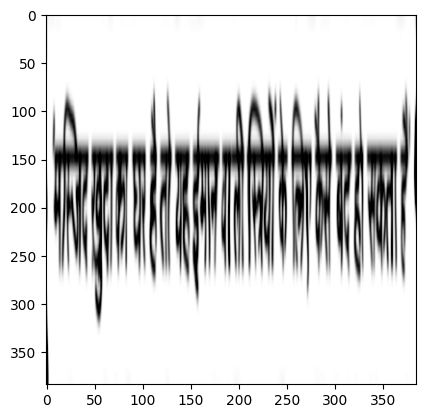

In [13]:
img_tensor = train_dataset[1]['pixel_values']
plt.imshow(img_tensor.permute(1,2,0))

In [14]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 72000
Number of validation examples: 8000


In [15]:
# check the first example for train_dataset
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)
print('\n')

# check the first example for eval_dataset
encode = eval_dataset[0]
for k,v in encode.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


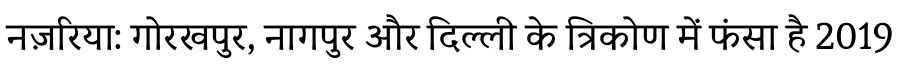

In [16]:
encoding=train_dataset[2]
image = Image.open(train_dataset.root_dir + df['image_file'][2]).convert("RGB")
image

In [17]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

नज़रिया : गोरखपुर, नागपुर और दिल्ली के त्रिकोण में फंसा है 2019


In [18]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("facebook/deit-base-distilled-patch16-384", "bert-base-multilingual-cased")
print(model.config.decoder.decoder_start_token_id)
model.to(device)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/351M [00:00<?, ?B/s]

Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bia

None


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [19]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [20]:
# defining our loss metrics
# from datasets import load_metric #(optional method)
from evaluate import load
cer_metric = load("cer")
wer_metric = load("wer")
# accuracy_metric = load("accuracy")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    # accuracy = accuracy_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer, "wer": wer}

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    fp16=True,
    fp16_full_eval=True,
#     dataloader_pin_memory=False,
#     optim="adamw_torch_fused",
#     dataloader_num_workers=4,
#     ddp_backend="nccl", # gloo cause we are using tpu, use nccl for gpu
#     fsdp="full_shard",
#     fsdp_config=fsdp_config,
#     torch_compile=True,
#     split_batches=4,
#     dataloader_persistent_workers=True,
    report_to="wandb",
    learning_rate=4e-5,
    output_dir="./",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="steps",
    resume_from_checkpoint=True,
    save_steps=8000,
    eval_steps=8000,
)

In [23]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()
#trainer.save_model('./model')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss,Cer,Wer
8000,0.780200,0.648265,0.202149,0.316029


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


KeyboardInterrupt: 

In [24]:
trainer.save_model('./model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


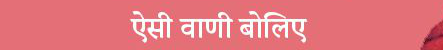

In [25]:
import requests
from io import StringIO
img=Image.open("/content/data_80k/TestSamples/1.png").convert("RGB")
img

In [26]:
import torch
import torchvision.transforms as v2
model = VisionEncoderDecoderModel.from_pretrained("/content/model")
# device = torch.device('cpu')
model= model.to(device)
model.eval()
transform = v2.Compose([
    v2.Resize((384,384)),
    v2.ToTensor(),
    v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])
img_t = transform(img).unsqueeze(0)
# p = processor(img, return_tensors="pt").pixel_values
p= img_t.to(device)

generated_ids = model.generate(p)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
print(generated_ids)

हिंदू मंदिर : चरमपंथी चिंतित हुए
tensor([[   101,    101,    899, 103435,  98626,  43799,    131,    870,  11549,
          13841,  18187, 106891,  10914,    870, 103435,  24877,  11845,  24734,
            102]], device='cuda:0')


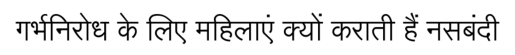

Image: /content/data_80k/output_images/1.png
Generated Text: पश्चिमी के लिए महिलाएं क्यों करती हैं नसबंदी
-------------------------xxxx-------------------------


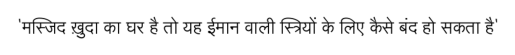

Image: /content/data_80k/output_images/2.png
Generated Text: ' स्वास्थ्य बुख़ार का घर से हो रहा ईरान वालों के लिए कितने कैसे बंद हो सकता है '
-------------------------xxxx-------------------------


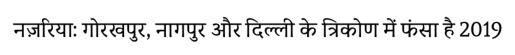

Image: /content/data_80k/output_images/3.png
Generated Text: नज़रिया : गोरखपुर, नागपुर और दिल्ली के किसानों में फंसा है?
-------------------------xxxx-------------------------


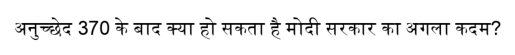

Image: /content/data_80k/output_images/4.png
Generated Text: अनुच्छेद 370 के बाद क्या हो सकता है मोदी सरकार का आपदा क्या?
-------------------------xxxx-------------------------


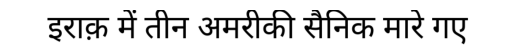

Image: /content/data_80k/output_images/5.png
Generated Text: इराक़ में तीन अमरीकी सैनिक मारे गए
-------------------------xxxx-------------------------


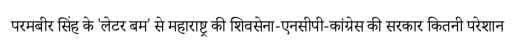

Image: /content/data_80k/output_images/6.png
Generated Text: परमाणु हमले के'बैठक'से सहयोग की ज़िम्मेदारी, एनसीएम - एनसीसी की सांसद कितनी मोदी सरकार
-------------------------xxxx-------------------------


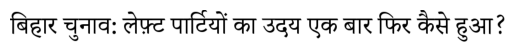

Image: /content/data_80k/output_images/7.png
Generated Text: बिहार चुनाव : लोग पार्टियाँ का उड़ा एक बार फिर कैसे हुआ?
-------------------------xxxx-------------------------


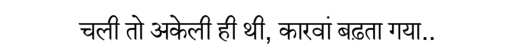

Image: /content/data_80k/output_images/8.png
Generated Text: चलती तो अकेली ही थी, कप्तान बढ़ा गया...
-------------------------xxxx-------------------------


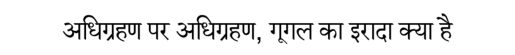

Image: /content/data_80k/output_images/9.png
Generated Text: अभिषेक पर अभियान, गूगल का इरादा क्या है
-------------------------xxxx-------------------------


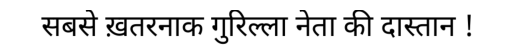

Image: /content/data_80k/output_images/10.png
Generated Text: सबसे ख़तरनाक पाकिस्तान नेता की दास्ता!
-------------------------xxxx-------------------------


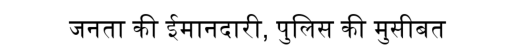

Image: /content/data_80k/output_images/11.png
Generated Text: जलवायु की ईमानदारी, पुलिस की मुसीबत
-------------------------xxxx-------------------------


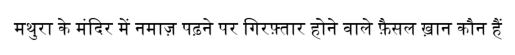

Image: /content/data_80k/output_images/12.png
Generated Text: मुशर्रफ़ के मंदिर में नफ़रत पढ़ने पर गिरफ़्तार होने वाला फ़ैसला कौन हैं
-------------------------xxxx-------------------------


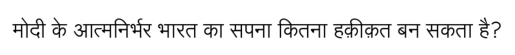

Image: /content/data_80k/output_images/13.png
Generated Text: मोदी के अस्पताल भारत का सामान कितना हक़ीक़त बन सकता है?
-------------------------xxxx-------------------------


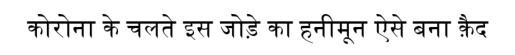

Image: /content/data_80k/output_images/14.png
Generated Text: कोरोना के चलते इस जोड़े का हनीमून ऐसे बना क़ैद
-------------------------xxxx-------------------------


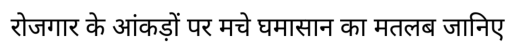

Image: /content/data_80k/output_images/15.png
Generated Text: रोजगार के आंकड़ों पर मचे प्रस्ताव का मतलब जानिए
-------------------------xxxx-------------------------


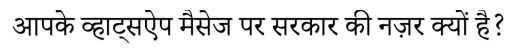

Image: /content/data_80k/output_images/16.png
Generated Text: आपके व्हाट्सऐप सेंसेक्स पर सरकार की नज़र क्यों है?
-------------------------xxxx-------------------------


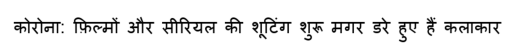

Image: /content/data_80k/output_images/17.png
Generated Text: कोरोना : फ़िलॉस और सीरिया की शीत युद्ध शुरू हो गए हैं कब्ज़ाम
-------------------------xxxx-------------------------


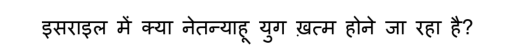

Image: /content/data_80k/output_images/18.png
Generated Text: इसराइल में क्या लेबनान यूएन ख़त्म होने जा रहा है?
-------------------------xxxx-------------------------


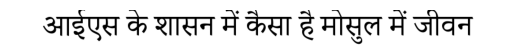

Image: /content/data_80k/output_images/19.png
Generated Text: आईएस के पास में कैमरा है मोमल में जीत
-------------------------xxxx-------------------------


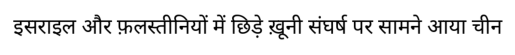

Image: /content/data_80k/output_images/20.png
Generated Text: इमरान और फ़लस्तीनियों में छिड़े गई संघर्ष पर समझे अप - पाक
-------------------------xxxx-------------------------


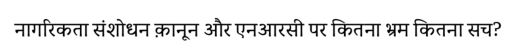

Image: /content/data_80k/output_images/21.png
Generated Text: नागरिकता संशोधन क़ानून और एनआरसी पर कितना भ्रष्टाचार मिला?
-------------------------xxxx-------------------------


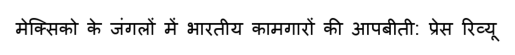

Image: /content/data_80k/output_images/22.png
Generated Text: मेक्सिको के जंगलों में भारतीय कामयाबों की आपबीती : प्रेस रिव्यू
-------------------------xxxx-------------------------


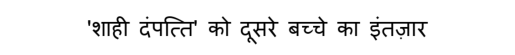

Image: /content/data_80k/output_images/23.png
Generated Text: ' शाही दलित'को दूसरे बच्चे का इंतज़ार
-------------------------xxxx-------------------------


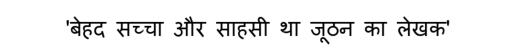

Image: /content/data_80k/output_images/24.png
Generated Text: ' बेहतर सच्चा और सहमति था न्यूज़ील का लोग '
-------------------------xxxx-------------------------


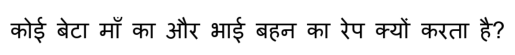

Image: /content/data_80k/output_images/25.png
Generated Text: कोई बेटा मैं काँ और भाई बहन का रेप क्यों कराता है?
-------------------------xxxx-------------------------


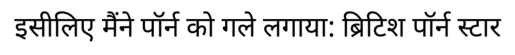

Image: /content/data_80k/output_images/26.png
Generated Text: इस्लामिए मैंने पाँच को जाने लगाया : ब्रिटेन पॉर्न्स
-------------------------xxxx-------------------------


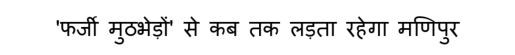

Image: /content/data_80k/output_images/27.png
Generated Text: ' फ़र्ज़ी मुठभेड़ों'से कब तक लड़ाकू होगा मुशर्रफ़
-------------------------xxxx-------------------------


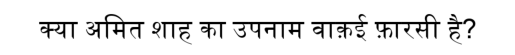

Image: /content/data_80k/output_images/28.png
Generated Text: क्या अमित शाह का उठाना वाक़ई फ़रारी है?
-------------------------xxxx-------------------------


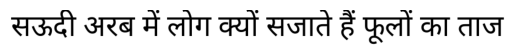

Image: /content/data_80k/output_images/29.png
Generated Text: सऊदी अरब में लोग क्यों सलाते हैं फूलों का लाल
-------------------------xxxx-------------------------


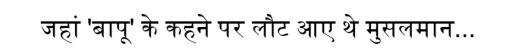

Image: /content/data_80k/output_images/30.png
Generated Text: जहां'वायु'के कहने पर लौटा आए थे मुसलमान...
-------------------------xxxx-------------------------


In [27]:
for i in range(1, 31):
    # Construct image path
    img_path = f"/content/data_80k/output_images/{i}.png"

    # Read and display image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Tokenize and preprocess image
    transform = v2.Compose([
        v2.Resize((384,384)),
        v2.ToTensor(),
        v2.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    img_t = transform(img).unsqueeze(0)
    p= img_t.to(device)

    # Generate text
    generated_ids = model.generate(p)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Print generated text
    print(f"Image: {img_path}")
    print(f"Generated Text: {generated_text}")
    print("-------------------------xxxx-------------------------")
